<a href="https://colab.research.google.com/github/dushyanthbommana/CE888/blob/main/Assignment2/Essex_Police_bias_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install aif360
pip install fairlearn


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
np.random.seed(1)

In [5]:
dataframe = pd.read_csv('https://raw.githubusercontent.com/dushyanthbommana/CE888/main/essex-stop-search.csv')

In [6]:
null = ['Part of a policing operation','Policing operation']
df = dataframe.drop(columns=null,axis=1)
df.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person search,2020-06-30T23:01:00+00:00,51.776969,1.119975,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,A no further action disposal,False,False
1,Person search,2020-06-30T23:01:00+00:00,51.884603,0.921385,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Summons / charged by post,False,False
2,Person search,2020-07-01T00:01:00+00:00,51.567500,0.434043,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,False,False
3,Person and Vehicle search,2020-07-01T02:01:00+00:00,51.585496,0.500271,Female,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False
4,Person and Vehicle search,2020-07-01T06:01:00+00:00,51.876726,1.006272,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,NaN,False,False


In [7]:
df_updated = df.drop(columns=['Date','Latitude','Longitude'])
df_updated.head(3)


,Type,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing
0,Person search,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,A no further action disposal,False,False
1,Person search,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Summons / charged by post,False,False
2,Person search,Male,18-24,White - English/Welsh/Scottish/Northern Irish/...,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,False,False


In [8]:
from sklearn import preprocessing 
label = preprocessing.LabelEncoder() 
cols=['Outcome linked to object of search','Removal of more than just outer clothing','Self-defined ethnicity']
df[cols] = df[cols].astype(str)
df1_lc = df[cols].apply(preprocessing.LabelEncoder().fit_transform)

In [ ]:
df1_lc.head(4)

,Outcome linked to object of search,Removal of more than just outer clothing,Self-defined ethnicity
0,0,0,13
1,0,0,13
2,1,0,15
3,1,0,15


In [9]:
df_onehot = pd.concat([df1_lc, pd.get_dummies(df[['Gender', 'Outcome']])], axis=1)

In [10]:
df_onehot.head(3)

,Outcome linked to object of search,Removal of more than just outer clothing,Self-defined ethnicity,Gender_Female,Gender_Male,Gender_Other,Outcome_A no further action disposal,Outcome_Arrest,Outcome_Caution (simple or conditional),Outcome_Community resolution,Outcome_Khat or Cannabis warning,Outcome_Penalty Notice for Disorder,Outcome_Summons / charged by post
0,0,0,15,0,1,0,1,0,0,0,0,0,0
1,0,0,15,0,1,0,0,0,0,0,0,0,1
2,0,0,15,0,1,0,1,0,0,0,0,0,0


In [11]:
df_final=df_onehot.dropna(axis=0)
df_final.head()

,Outcome linked to object of search,Removal of more than just outer clothing,Self-defined ethnicity,Gender_Female,Gender_Male,Gender_Other,Outcome_A no further action disposal,Outcome_Arrest,Outcome_Caution (simple or conditional),Outcome_Community resolution,Outcome_Khat or Cannabis warning,Outcome_Penalty Notice for Disorder,Outcome_Summons / charged by post
0,0,0,15,0,1,0,1,0,0,0,0,0,0
1,0,0,15,0,1,0,0,0,0,0,0,0,1
2,0,0,15,0,1,0,1,0,0,0,0,0,0
3,0,0,15,1,0,0,1,0,0,0,0,0,0
4,0,0,15,0,1,0,0,0,0,0,0,0,0


In [12]:
df_final['Outcome linked to object of search'].value_counts()

2    4388
0    2719
1     683
Name: Outcome linked to object of search, dtype: int64

In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7790 entries, 0 to 7789
Data columns (total 13 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Outcome linked to object of search        7790 non-null   int64
 1   Removal of more than just outer clothing  7790 non-null   int64
 2   Self-defined ethnicity                    7790 non-null   int64
 3   Gender_Female                             7790 non-null   uint8
 4   Gender_Male                               7790 non-null   uint8
 5   Gender_Other                              7790 non-null   uint8
 6   Outcome_A no further action disposal      7790 non-null   uint8
 7   Outcome_Arrest                            7790 non-null   uint8
 8   Outcome_Caution (simple or conditional)   7790 non-null   uint8
 9   Outcome_Community resolution              7790 non-null   uint8
 10  Outcome_Khat or Cannabis warning          7790 non-null   ui

In [14]:
df_aif = BinaryLabelDataset(df= df_final.drop(['Gender_Female','Outcome_A no further action disposal','Outcome_Caution (simple or conditional)','Outcome_Khat or Cannabis warning','Outcome_Penalty Notice for Disorder','Outcome_Penalty Notice for Disorder','Outcome_Summons / charged by post'], axis=1), label_names=['Gender_Male'], protected_attribute_names=['Outcome_Arrest'])

In [15]:
df_aif

               instance weights  ... labels
                                 ...       
                                 ...       
instance names                   ...       
0                           1.0  ...    1.0
1                           1.0  ...    1.0
2                           1.0  ...    1.0
3                           1.0  ...    0.0
4                           1.0  ...    1.0
...                         ...  ...    ...
7785                        1.0  ...    1.0
7786                        1.0  ...    1.0
7787                        1.0  ...    0.0
7788                        1.0  ...    1.0
7789                        1.0  ...    1.0

[7790 rows x 8 columns]

In [16]:
privileged_group = [{'Outcome_Arrest': 0}]
unprivileged_group = [{'Outcome_Arrest': 1}]

In [27]:
def get_disparity_index(di):
    return 1 - np.minimum(di, 1 / di)


def get_bal_acc(classified_metric):
    return 0.5 * (classified_metric.true_positive_rate() + classified_metric.true_negative_rate())


def train_lr_model(dataset):
    scale = StandardScaler().fit(dataset.features)
    model = LogisticRegression(random_state=0, solver='liblinear')
    x_train = scale.transform(dataset.features)
    y_train = dataset.labels.ravel()
    model.fit(x_train, y_train, sample_weight=dataset.instance_weights)
    y_train_pred = model.predict(x_train)
    return model, scale


def test_lr_model(y_data_pred_prob, dataset, thresh_arr):
    y_pred = (y_data_pred_prob[:,1] > thresh_arr).astype(np.double)
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
    return dataset_pred.labels, classified_metric, metric_pred


def get_y_pred_prob_lr(scale, model, dataset):
    x = scale.transform(dataset.features)
    y_pred_prob = model.predict_proba(x)
    return y_pred_prob


def get_best_bal_acc_cutoff(y_pred_prob, dataset):
    y_validate_pred_prob = y_pred_prob
    bal_acc_arr = []
    disp_imp_arr = []

    for thresh in tqdm(thresh_arr):
        y_validate_pred = (y_validate_pred_prob[:,1] > thresh).astype(np.double)
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_validate_pred

        # Calculate accuracy for each threshold value
        classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_group, privileged_group)
        bal_acc = get_bal_acc(classified_metric)
        bal_acc_arr.append(bal_acc)

        # Calculate fairness for each threshold value
        metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_group, privileged_group)
        disp_imp_arr.append(metric_pred.disparate_impact())

    # Find threshold for best accuracy
    thresh_arr_best_ind = np.where(bal_acc_arr == np.max(bal_acc_arr))[0][0]
    thresh_arr_best = np.array(thresh_arr)[thresh_arr_best_ind]

    # Calculate accuracy and fairness at this threshold
    best_bal_acc = bal_acc_arr[thresh_arr_best_ind]
    disp_imp_at_best_bal_acc = disp_imp_arr[thresh_arr_best_ind]

    # Output metrics
    acc_metrics = pd.DataFrame({'thresh_arr_best_ind' : thresh_arr_best_ind, \
    'thresh_arr_best' : thresh_arr_best, \
    'best_bal_acc' : best_bal_acc, \
    'disp_imp_at_best_bal_acc' : disp_imp_at_best_bal_acc}, index=[0]).transpose()
    return acc_metrics, bal_acc_arr, disp_imp_arr, dataset_pred.labels


def plot_acc_vs_fairness(metric, metric_name, bal_acc_arr, thresh_arr_best_ind):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    ax1.plot(thresh_arr, bal_acc_arr, color='b')
    ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14, labelcolor='b')
    ax2 = ax1.twinx()
    ax2.plot(thresh_arr, metric, color='r')
    ax2.set_ylabel(metric_name, color='r', fontsize=16, fontweight='bold')
    ax2.axvline(np.array(thresh_arr)[thresh_arr_best_ind], color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14, labelcolor='r')
    ax2.grid(True)

In [17]:
df_orig_trn, df_orig_val, df_orig_tst = df_aif.split([0.5, 0.8], shuffle=True)
print([x.features.shape for x in [df_orig_trn, df_orig_val, df_orig_tst]])

[(3895, 6), (2337, 6), (1558, 6)]


In [28]:
from aif360.algorithms import Transformer
from aif360.metrics import BinaryLabelDatasetMetric
metric_orig_trn = BinaryLabelDatasetMetric(df_orig_trn, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig_trn.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.057


In [29]:
lr_orig, lr_scale_orig = train_lr_model(df_orig_trn)
thresh_arr = np.linspace(0.01, 0.8, 100)
y_validate_pred_prob_orig = get_y_pred_prob_lr(scale=lr_scale_orig, model=lr_orig, dataset=df_orig_val)


In [30]:
from aif360.metrics import ClassificationMetric
acc_metrics_orig, bal_acc_arr_orig, disp_imp_arr_orig, dataset_pred_labels_orig = \
get_best_bal_acc_cutoff(y_pred_prob=y_validate_pred_prob_orig, dataset=df_orig_val)

100%|██████████| 100/100 [00:00<00:00, 578.68it/s]


In [31]:
print('Threshold corresponding to best balanced accuracy:', acc_metrics_orig.loc['thresh_arr_best', 0].round(3))
print('Best balanced accuracy:', acc_metrics_orig.loc['best_bal_acc', 0].round(3))
print('1-min(DI, 1/DI):', get_disparity_index(acc_metrics_orig.loc['disp_imp_at_best_bal_acc', 0]).round(3))

Threshold corresponding to best balanced accuracy: 0.736
Best balanced accuracy: 0.691
1-min(DI, 1/DI): 0.001


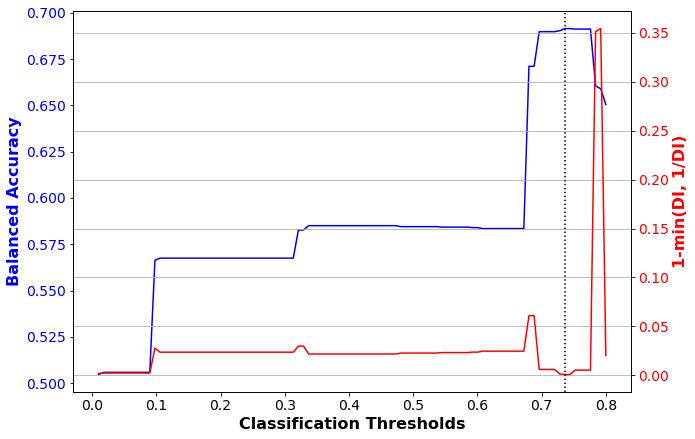

In [32]:
plot_acc_vs_fairness(get_disparity_index(np.array(disp_imp_arr_orig)), \
  '1-min(DI, 1/DI)', bal_acc_arr_orig, \
  acc_metrics_orig.loc['thresh_arr_best_ind', 0].astype(int))